# Data imbalance analysis
## Comparing the impact of dataset imbalance on classification performance metrics
In this notebook, we are going to explore how data imbalance affect classification scores on four different tasks, which have been chosen to exemplify typical use cases of ML analysis in neuroscience. To keep it simple, we will focus on binary classification problems (0 vs 1).

The four tasks are :
1. Synthetic data
2. EEG alpha oscillations (resting-state Eyes-Closed vs Eyes-Open)
3. MEG alpha oscillations (auditory vs visual stimulation)
4. MEG alpha oscillations (faces vs scrambled) 

In these tasks, we will observe the effect of data imbalance on 4 different performance metrics :   
1. Decoding Accuracy (Acc)  
2. Area Under the Curve (AUC)
3. F1
4. Balanced Accuracy (BAcc)

Finally, a few parameters of the classification pipeline must be kept in mind as they can also differentially impact performance on imbalanced data. Namely :
- Dataset size
- Classifier type
    - Support Vector Machine (SVM)
    - Linear Discriminant Analysis (LDA)
    - Logistic Regression (LR)
    - Random Forest (RF)
- Cross-validation scheme
    - K-Fold, k=5
    - Stratified K-Fold
    - Group K-Fold

## Imports
First, we start by importing functions from the provided toolbox as well as some useful plotting functions.

In [1]:
import copy
from imbalance.pipeline import Pipeline
from imbalance.viz import metric_balance, data_distribution, plot_different_cvs, plot_different_n
from imbalance.data import eegbci, gaussian_binary, fmri_haxby
from joblib import Parallel, delayed
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    StratifiedGroupKFold,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import string
from copy import deepcopy
import pickle
import warnings
warnings.simplefilter("ignore", RuntimeWarning)
plt.style.use('seaborn-dark')

c:\Users\pthoe\miniconda3\envs\imbalance\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## Task 1 : Synthetic data
For that first classification task, we will generate data from two gaussian distributions, with means of 0 and 2.

### Classifier overview

In [ ]:
pls = []

def run(distance):
    # generate random data
    x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=distance)
    # run the pipeline
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=["lr", "lda", "svm", "rf"],
        n_permutations=100,
        n_init=40,
    )
    pl.evaluate()
    return deepcopy(pl)



pls = Parallel(n_jobs=-1)(delayed(run)(dist) for dist in [0, 1, 3])

In [ ]:
pls_path = "../imbalance/data/synthetic_pipelines.pickle"
with open(pls_path, "wb") as f:
    pickle.dump(pls, f)

### Impact of sample size

In [ ]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=1500, mean_distance=1)
# run the pipeline
pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=40,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()

In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_nsamples.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pl_nsamples, f)

### Cross-validation strategy

In [ ]:
n_inits = 40
pls_crossvals = {}
cv_names = ["KFold", "Stratified"]#, "Stratified Group"]
cvs = [KFold(n_splits=5), StratifiedKFold(n_splits=5)]#, StratifiedGroupKFold(n_splits=5)]

scores = {}
for idx_init in range(n_inits):
    # generate random data
    # /!\ N=100 in this analysis
    x, y, groups = gaussian_binary(n_samples_per_class=50, mean_distance=1, rand_seed=idx_init)
    
    # run the pipeline
    for idx_cv, cross_val in enumerate(cvs):
        pl = Pipeline(
            x,
            y,
            groups,
            dataset_balance=np.linspace(0.1, 0.9, 25),
            classifiers=["svm"],
            n_permutations=1,
            n_init=1,
            cross_validation=cross_val,
            rand_seed=idx_init,
        )
        pl.evaluate()
        pl = deepcopy(pl)
        
        pls_crossvals[cv_names[idx_cv]] = pl
        
        if cv_names[idx_cv] not in scores:
            scores[cv_names[idx_cv]] = pl.scores
        else:
            for ratio in pl.scores.keys():
                for size in pl.scores[ratio].keys():
                    for clf in pl.scores[ratio][size].keys():
                        for metric in pl.scores[ratio][size][clf].keys():
                            if isinstance(scores[cv_names[idx_cv]][ratio][size][clf][metric], tuple):
                                # use only the mean
                                scores[cv_names[idx_cv]][ratio][size][clf][metric] = [scores[cv_names[idx_cv]][ratio][size][clf][metric][0]]
                            
                            # add current pipeline's score to the list
                            scores[cv_names[idx_cv]][ratio][size][clf][metric].append(
                                pl.scores[ratio][size][clf][metric][0]
                            )

# compute mean and std score
for cv_name in cv_names:
    curr_scores = scores[cv_name]
    for ratio in curr_scores.keys():
        for size in curr_scores[ratio].keys():
            for clf in curr_scores[ratio][size].keys():
                for metric in curr_scores[ratio][size][clf].keys():
                    curr_scores[ratio][size][clf][metric] = (np.mean(curr_scores[ratio][size][clf][metric]),
                                                             np.std(curr_scores[ratio][size][clf][metric]),
                                                             None,
                                                             None)
    pls_crossvals[cv_name].scores = curr_scores

In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_crossvals.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pls_crossvals, f)

### Balanced hold-out set

In [ ]:
# generate random data
x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=1)
# run the pipeline
pl_balance = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],
    n_permutations=0,
    n_init=40,
    single_balanced_split=True,
)
pl_balance.evaluate()

In [ ]:
pl_path = "../imbalance/data/synthetic_pipelines_balance.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(pl_balance, f)

### Linear SVM

In [ ]:
lin_pls = []
for distance in [0, 1, 3]:
    # generate random data
    x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=distance)
    # run the pipeline
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers=[SVC(kernel="linear", probability=True)],
        n_permutations=100,
        n_init=10,
    )
    pl.evaluate()
    lin_pls.append(pl)

In [ ]:
pl_path = "../imbalance/data/linSVM.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(lin_pls, f)

## Generate figures

In [ ]:
# load data
with open("../imbalance/data/synthetic_pipelines.pickle", "rb") as f:
    pls = pickle.load(f)

# visualize the result
fig, axes = plt.subplots(5, 4, figsize=(15, 22), dpi=300, 
                         gridspec_kw=dict(height_ratios=[1, 1, 1, 1, 1], width_ratios=[0.1,1,1,1],
                                          hspace=0.3))
for ax in axes[:,0]:                              
    ax.axis("off")

figtitle = "Synthetic data"
fig.suptitle(figtitle, fontsize=20, y=0.92, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]
spot_names = string.ascii_lowercase[:5*4]

show_leg_distrib=True
show_leg_metric=False
spot_idx = 0
for dist_idx, dist in enumerate([0,1,3]):
    for ax_idx, ax in enumerate(axes[:,dist_idx+1]):
        if dist_idx == 2 and ax_idx == 0:
            show_leg_metric = True
        
        if ax_idx == 0:
            data_distribution(pls[dist_idx], ax=ax, show=False, show_leg=show_leg_distrib)
            show_leg_distrib=False
        elif ax_idx < 5:
            metric_balance(pls[dist_idx], ax=ax, p_threshold=0, show=False, 
                           classifier=classifiers[ax_idx-1], 
                           show_leg=show_leg_metric, show_title=False)
            show_leg_metric = False
        
        ax.text(-0.12, 1.12, spot_names[spot_idx]+")", transform=ax.transAxes, 
                size=22, weight='bold')
        spot_idx += 1

cols = ['Distance = 0', 'Distance = 1', 'Distance = 3']
rows = ["Distributions", "LogisticRegression", "LinearDiscriminantAnalysis", "SupportVectorMachine", "RandomForest"]

for ax, col in zip(axes[0,1:], cols):
    ax.set_title(col, size=20)

for idx_ax, (ax, row) in enumerate(zip(axes[:,0], rows)):
    ax.text(0.8,0.5,rows[idx_ax], fontsize=20, ha="right", va="center", rotation=90)

fig.tight_layout()
plt.savefig("Figure2.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# load data
with open("../imbalance/data/linSVM.pickle", "rb") as f:
    pls = pickle.load(f)

# visualize the result
fig, axes = plt.subplots(2, 4, figsize=(15, 10), dpi=300, 
                         gridspec_kw=dict(width_ratios=[0.1,1,1,1], hspace=0.3))
for ax in axes[:,0]:                              
    ax.axis("off")

figtitle = "Linear SVM"
fig.suptitle(figtitle, fontsize=20, y=0.95, fontweight="bold")
classifiers=["svm"]
spot_names = string.ascii_lowercase[:5*4]

show_leg_distrib=True
show_leg_metric=False
spot_idx = 0
for dist_idx, dist in enumerate([0,1,3]):
    for ax_idx, ax in enumerate(axes[:,dist_idx+1]):
        if dist_idx == 2 and ax_idx == 0:
            show_leg_metric = True
        
        if ax_idx == 0:
            data_distribution(pls[dist_idx], ax=ax, show=False, show_leg=show_leg_distrib)
            show_leg_distrib=False
            ax.text(-0.12, 1.05, spot_names[spot_idx]+")", transform=ax.transAxes, 
                    size=22, weight='bold')
            spot_idx += 1
        elif ax_idx < 5:
            metric_balance(pls[dist_idx], ax=ax, p_threshold=0, show=False, 
                           classifier=classifiers[ax_idx-1], 
                           show_leg=show_leg_metric, show_title=False)
            show_leg_metric = False
        

cols = ['Distance = 0', 'Distance = 1', 'Distance = 3']
rows = ["Distributions", "Linear SVM"]

for ax, col in zip(axes[0,1:], cols):
    ax.set_title(col, size=20)

for idx_ax, (ax, row) in enumerate(zip(axes[:,0], rows)):
    ax.text(0.8,0.5,rows[idx_ax], fontsize=20, ha="right", va="center", rotation=90)

fig.tight_layout()
plt.savefig("Figure8_supp.pdf", bbox_inches="tight")
plt.show()

In [ ]:
with open("../imbalance/data/synthetic_pipelines_nsamples.pickle", "rb") as f:
    pl_nsamples = pickle.load(f)
with open("../imbalance/data/synthetic_pipelines_crossvals.pickle", "rb") as f:
    pls_crossvals = pickle.load(f)
with open("../imbalance/data/synthetic_pipelines_balance.pickle", "rb") as f:
    pl_balance = pickle.load(f)
with open("../imbalance/data/hparams_pipelines.pickle", "rb") as f:
    pls_hparams = pickle.load(f)

fig, axes = plt.subplots(2, 3, figsize=(22, 13), dpi=300, gridspec_kw=dict(hspace=0.2))
figtitle = "Synthetic data : secondary parameters"
fig.suptitle(figtitle, fontsize=28, y=0.96, fontweight="bold")

# hyperparameters (first row)
for clf_idx, clf_name in enumerate(pls_hparams.keys()):
    lines = []
    for i_pl, curr_pl in enumerate(pls_hparams[clf_name].values()):
        lines.extend(metric_balance(curr_pl, classifier=clf_name, color_offset=i_pl, ax=axes[0, clf_idx], 
                                    ignore_metrics=["roc_auc", "f1", "accuracy"],
                                    show=False, show_leg=True, enforce_ylim=False, reset_colors=True))
    axes[0, clf_idx].legend(lines, pls_hparams[clf_name].keys(), prop={'size': 14})
    axes[0, clf_idx].set_ylabel("Balanced Accuracy", size=16)
    
# other analysis (second row)
plot_different_n(pl_nsamples, ax=axes[1,0], show=False, classifier="svm", show_leg=True, metric="accuracy",
                 legend_labels=["N=300", "N=1000", "N=3000"])
axes[1,0].set_title('Accuracy vs sample size (SVM)', size=18)

plot_different_cvs(pls_crossvals, ax=axes[1,1], show=False, classifier="svm", show_leg=True,
                   metric="balanced_accuracy")
axes[1,1].set_title('Balanced Accuracy vs cross-validation (SVM)', size=18)

metric_balance(pl_balance, ax=axes[1,2], show=False, classifier="svm", show_leg=True, chance_leg=False,
               ignore_metrics=['balanced_accuracy'])
axes[1,2].set_title('Balanced Hold-out set (SVM)', size=18)

spot_names = string.ascii_lowercase[:5*4]
for ax_idx, ax in enumerate(axes.flat):
    ax.text(-0.1, 1.07, spot_names[ax_idx]+")", transform=ax.transAxes, 
            size=26, weight='bold')

plt.subplots_adjust()
plt.savefig("Figure3.pdf", bbox_inches="tight")

## Task 2 : EEG analysis

In [ ]:
#pipeline_path="../imbalance/data/eeg.pickle"
features_path ="../imbalance/data/eeg_features.npy"

# load or generate dataset
if not os.path.isfile(features_path):
    x, y, groups = eegbci('../imbalance/data',roi=lambda x: x[0] in ['P','O'])
    np.save(features_path,dict(x=x, y=y, groups=groups))
else:
    features = np.load(features_path,allow_pickle=True).item()
    x, y, groups = features["x"] , features["y"] , features["groups"]

In [ ]:
pl = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["lda","svm","lr", "rf"]
)
# fit and evaluate classifiers on dataset configurations
pl.evaluate()

pl_nsamples = Pipeline(
    x,
    y,
    groups,
    dataset_balance=np.linspace(0.1, 0.9, 25),
    classifiers=["svm"],# "rf"]
    n_permutations=0,
    n_init=10,
    dataset_size=(0.1, 0.33, 1),
)
pl_nsamples.evaluate()

In [ ]:
fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)

def task_panel(pl: Pipeline, figtitle: str=[], class_names=[]):
    # visualize the result
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    #fig.suptitle(figtitle, fontsize=25)
    classifiers=["lr", "lda", "svm", "rf"]
    show_leg_metric=True
    for ax_idx,ax in enumerate(axes.flat):
        if ax_idx != 5:
            ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
                    size=22, weight='bold')
        if ax_idx == 0:
            data_distribution(pl, ax=ax, show=False, class_names=class_names)
        elif ax_idx < 5:
            metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1], p_threshold=0, show_leg=show_leg_metric)
            show_leg_metric=False
        elif ax_idx == 5:
            ax.axis('off')
            #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
    plt.show()

figtitle = "EEG data multi"
task_panel(pl, figtitle, ['Eyes closed', 'Eyes open'])

In [ ]:
from imbalance.data.eeg import get_info
import mne

fpath = "../imbalance/data/eeg_roi_multi_Stratified-Group.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
#tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "EEG : Eyes Closed VS Open"
class_names = ['Eyes Closed', 'Eyes Open']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(figtitle, fontsize=28, y=0.97, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=axes[0,0], show=False, class_names=class_names)
#axes[0,0].set_xlim(-2.5,5)
axes[1,0].axis('off')

info = get_info()
roi = [x for x in info['ch_names'] if x[0] in ['P','O']]
sphere=(0, 0.015, 0.01, 0.115)

metric_balance(pl, ax=axes[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=axes[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

for ax_idx,ax in enumerate(axes.T.flat):
    ax.text(-0.1, 1.075, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
            size=26, weight='bold')

# plot topomap and highlight selected sensors
crange = np.linspace(1, 0, 100)
cm = ListedColormap(np.stack((np.ones(len(crange)), crange, crange, np.ones(len(crange))), axis=1))
mask = np.array(list(map(lambda x: x.startswith(("O", "P")), info.ch_names)))
vals = np.zeros(len(info.ch_names))
vals[mask] = 1
with sns.axes_style("white"):
    mne.viz.plot_sensors(info, axes=axes[1,0], show=False, sphere=sphere)
    #mne.viz.plot_topomap(vals, info, axes=axes[1,0], image_interp="sinc", res=62, show=False,
    #                     sphere=(0, 0.018, 0.01, 0.1), show_names=False, contours=False, extrapolate="local",
    #                     vmin=0, vmax=4, cmap=cm, mask=np.ones(vals.shape),
    #                     mask_params=dict(marker="o", markersize=6, markerfacecolor="0"))
    
plt.savefig("Figure4.pdf", bbox_inches="tight")
plt.show()

## Task 3 : MEG 1

In [ ]:
from scipy.stats import ttest_ind
import string
from copy import deepcopy
import pickle
import numpy as np
import mne
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_info():
    data_path = mne.datasets.sample.data_path()
    raw = mne.io.read_raw_fif(
        f"{data_path}/MEG/sample/sample_audvis_raw.fif", preload=False
    )
    return raw.pick_types(meg="mag").info

def generate_topomap(
    data,
    elec=None,
    ax= None,
    vmin=None,
    vmax=None,
    res=128,
    cmap="viridis",
    colorbar=True,
    tight_layout=True,
    mask=None,
    mask_params=None,
):    
    if elec is not None:
        mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=20)
        mask = np.zeros(102).astype(bool)
        mask[elec] = True
    
    if ax is None:
        fig, ax = plt.subplots()
    
    im, _ = plot_topomap(
        data,
        load_info(),
        axes=ax,
        res=128,
        cmap=cmap,
        vmax=data.max() if vmax is None else vmax,
        vmin=data.min() if vmin is None else vmin,
        show=False,
        show_names=False,
        contours=False,
        sensors=False,
        extrapolate="local",
        mask=mask,
        mask_params=mask_params,
    )
    
    divider = make_axes_locatable(ax)
    ax_colorbar = divider.append_axes('bottom', size='5%', pad=0.05)
    plt.colorbar(im, cax=ax_colorbar, orientation='horizontal')
    ax_colorbar.set_xlabel('t-values', fontsize=16)

In [ ]:
plt.rcParams.update({"axes.edgecolor": "black"})

fpath = "../imbalance/data/MEG_gamma1_imbalance_78.pckl"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "MEG Cam-CAN : Visual VS Auditory stimulation"
class_names = ['Visual', 'Auditory']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(figtitle, fontsize=28, y=1.02, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=axes[0,0], show=False, class_names=class_names)
axes[0,0].set_xlim(-2.5,5)

generate_topomap(tval, ax=axes[1,0], elec=78)
axes[1,0].set_xlabel('T-values', fontsize=16)

metric_balance(pl, ax=axes[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=axes[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=axes[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

for ax_idx,ax in enumerate(axes.T.flat):
    ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
        size=24, weight='bold')
plt.savefig("Figure6.pdf", bbox_inches="tight")

plt.rcParams.update({"axes.edgecolor": "white"})

## Task 4 : MEG 2

In [ ]:

fpath = "../imbalance/data/MEG_gamma1_imbalance_78.pckl"
with open(fpath, "rb") as f:
    pl = pickle.load(f)
tval = np.load("../imbalance/data/gamma1_tvalues.npy")    

figtitle = "MEG Cam-CAN : Visual VS Auditory stimulation"
class_names = ['Visual', 'Auditory']
# visualize the result
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle(figtitle, fontsize=28, y=1.02, fontweight="bold")
classifiers=["lr", "lda", "svm", "rf"]

data_distribution(pl, ax=[0,0], show=False, class_names=class_names)
axes[0,0].set_xlim(-2.5,5)

generate_topomap(tval, ax=ax[1,0], elec=78)

metric_balance(pl, ax=ax[0,1], show=False, classifier="lr", p_threshold=0, show_leg=True)
metric_balance(pl, ax=ax[0,2], show=False, classifier="lda", p_threshold=0, show_leg=False)
metric_balance(pl, ax=ax[1,1], show=False, classifier="svm", p_threshold=0, show_leg=False)
metric_balance(pl, ax=ax[1,2], show=False, classifier="rf", p_threshold=0, show_leg=False)

show_leg_metric=True
for ax_idx,ax in enumerate(axes.flat):
    if ax_idx != 5:
        ax.text(-0.1, 1.05, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
                size=20, weight='bold')
    if ax_idx == 0:
        data_distribution(pl, ax=ax, show=False, class_names=class_names)
        ax.set_xlim(-2.5,5)
    elif ax_idx < 5:
        metric_balance(pl, ax=ax, show=False, classifier=classifiers[ax_idx-1], p_threshold=0, show_leg=show_leg_metric)
        show_leg_metric=False
    elif ax_idx == 5:
        generate_topomap(tval, ax=ax, elec=78)
        #ax.axis('off')
        #plot_different_n(pl_nsamples, ax=ax, show=False, classifier="svm", show_leg=True, metric="accuracy")
plt.show()

#task_panel(pl, figtitle, '])

# Task 5: fMRI

In [40]:
from nilearn.plotting import plot_stat_map

# load the data
x, y, masker, haxby_dataset = fmri_haxby("../data", return_nilearn=True)
# train a logistic regression for illustrative purposes
clf = LogisticRegression(max_iter=1000, penalty="l2", C=1)
clf.fit(x, y)
# show the weights
inv_coef = masker.inverse_transform(clf.coef_)

c:\Users\pthoe\miniconda3\envs\imbalance\lib\site-packages\nilearn\image\resampling.py:494: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
c:\Users\pthoe\miniconda3\envs\imbalance\lib\site-packages\joblib\memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


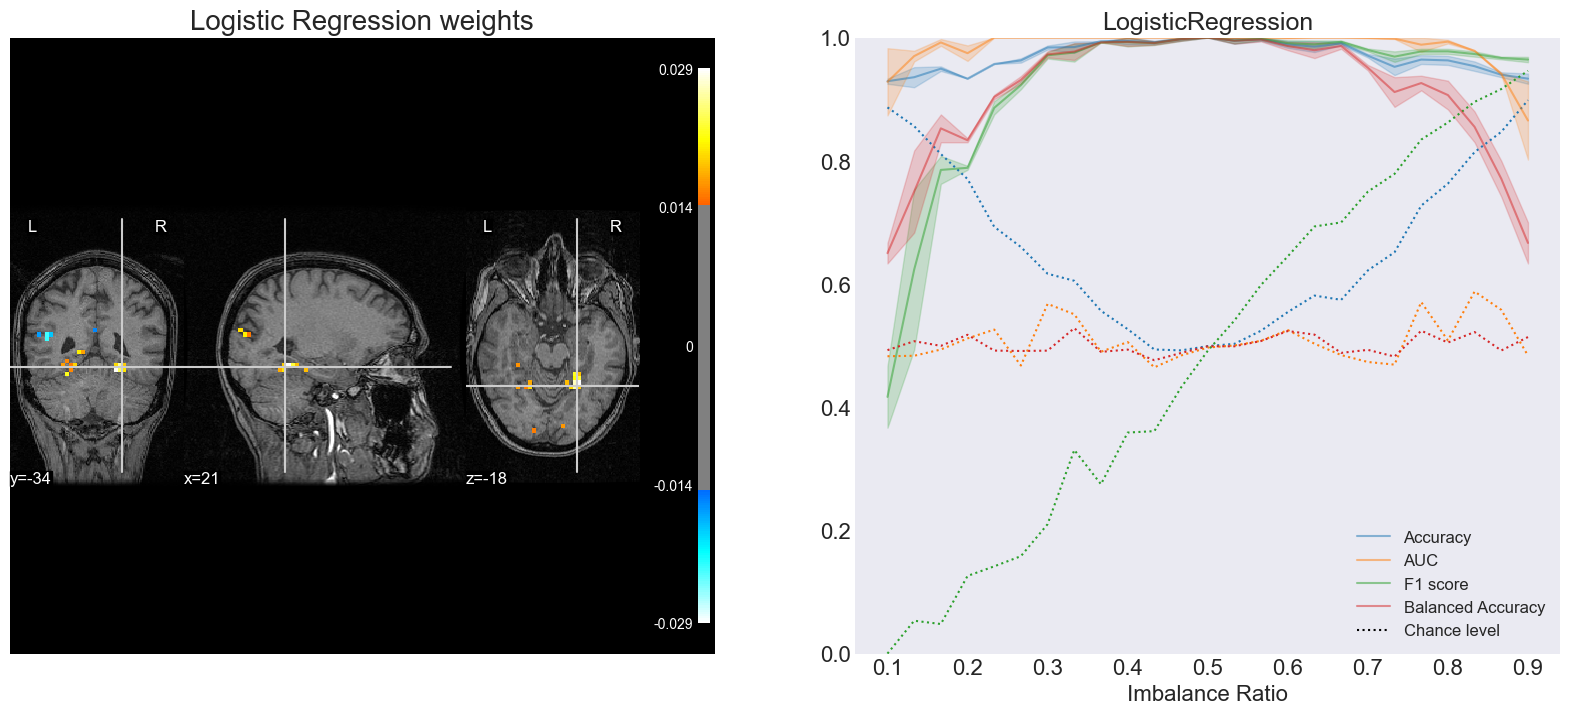

In [42]:
fpath = "../data/fmri.pickle"
with open(fpath, "rb") as f:
    pl = pickle.load(f)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].set_title("Logistic Regression weights", fontsize=20)
plot_stat_map(inv_coef, bg_img=haxby_dataset.anat[0], threshold=0.015, cut_coords=(21, -34, -18),
                          draw_cross=True, dim=-1, axes=axes[0])

metric_balance(pl, classifier="lr", ax=axes[1], show=False)

fig.savefig("Figure7.pdf", bbox_inches="tight")
plt.show()

# Significance testing

In [ ]:
def run_pipeline_significance(dist):
    # generate random data
    x, y, groups = gaussian_binary(n_samples_per_class=500, mean_distance=dist)
    # run the pipeline
    pl = Pipeline(
        x,
        y,
        groups,
        dataset_balance=np.linspace(0.1, 0.9, 25),
        classifiers="svm",
        n_permutations=100,
        n_init=1,
    )
    pl.evaluate()
    return dist, pl

results = Parallel(n_jobs=-1)(delayed(run_pipeline_significance)(dist) for dist in [0, 1, 3])
results = dict(results)

pl_path = "../imbalance/data/synthetic_pipelines_significance.pickle"
with open(pl_path, "wb") as f:
    pickle.dump(results, f)

In [ ]:
with open("../imbalance/data/synthetic_pipelines_significance.pickle", "rb") as f:
    pl_significance = pickle.load(f)

fig, axes = plt.subplots(ncols=len(pl_significance), figsize=(18, 5))
for i, (dist, pl) in enumerate(pl_significance.items()):
    show_leg = dist == list(pl_significance.keys())[-1]
    metric_balance(pl, classifier="svm", ax=axes[i], show=False, show_leg=show_leg)
    axes[i].set_title(f"Distance = {dist} (SVM)", fontsize=20)
    
for ax_idx, ax in enumerate(axes):
    ax.text(-0.1, 1.09, string.ascii_lowercase[ax_idx]+")", transform=ax.transAxes, 
            size=22, weight='bold')

plt.savefig("Figure7_supp.pdf", bbox_inches="tight")
plt.show()